# Solar Image segmentation

By: Dhyan MS and Kashish Varma

#### **Image segmentation:** it is the process of partitioning an image into multiple segments (sets of pixels) to simplify the representation of an image or make it more meaningful and easier to analyze.

#### The goal of segmentation is to locate objects and boundaries in images.


---


#### Image segmentation is used to identify and classify different solar phenomena, such as coronal holes, sunspots, and solar flares, in a given picture.

#### This is achieved by integrating deep learning (autoencoder) and classical machine learning (K-means clustering) techniques to segment the solar images. Each component of the project plays a crucial role in achieving accurate and meaningful segmentation, aiding in the study and analysis of solar phenomena like solar flares, coronal holes, sunspots, and quiet regions.

**1. Solar Flare**

Solar flares are sudden and intense bursts of radiation emanating from the Sun's atmosphere.They involve a massive amount of energy released in the form of light, X-rays, and gamma rays.

**Characteristics:**

* Bright and Intense: Solar flares are very bright in images, especially in X-ray and UV wavelengths.
*  Short-lived: They last from minutes to hours.
* Associated with Active Regions: Often found near sunspots and magnetic field lines.
* Segmentation Goal: Identify bright, intense regions with distinct boundaries.


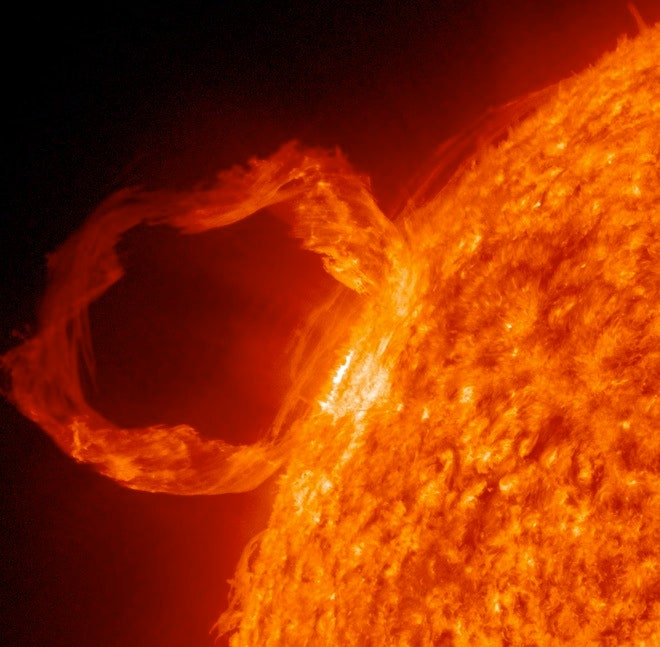

---

2. Coronal Hole

Coronal holes are areas on the Sun's corona that appear darker, cooler, and have lower-density plasma.

These regions are sources of high-speed solar wind streams that can impact space weather.

**Characteristics:**

* Dark Regions: Appear dark in UV and X-ray images due to lower temperature and density.
* Large-scale Structures: Can cover significant portions of the solar surface.
* Open Magnetic Field Lines: Associated with open magnetic field lines from which solar wind escapes.
* Segmentation Goal: Detect darker regions with less intense emission compared to the surrounding areas.

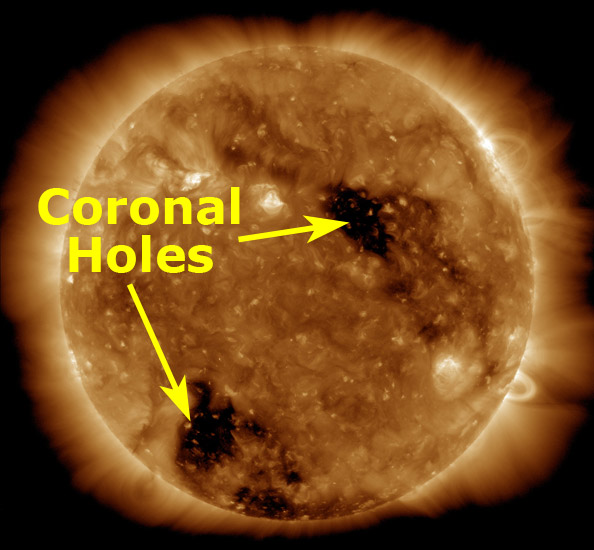

---



3. Quiet Region

Quiet regions on the Sun are areas with minimal solar activity, showing fewer sunspots, flares, or other dynamic phenomena. These regions are relatively stable and less energetic.

Characteristics:

* Stable Emission: Show consistent and lower intensity emission.
* Lack of Dynamic Features: Absence of sunspots, flares, and coronal holes.
* Uniform Appearance: Appear more uniform in images.
* Segmentation Goal: Identify stable, less active areas with uniform brightness.


---


4. Sunspots

Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are caused by intense magnetic activity, which inhibits convection and reduces surface temperature.

Characteristics:

* Dark Spots: Appear dark due to lower temperatures compared to the surrounding photosphere.
* Magnetic Activity: Associated with strong magnetic fields.
* Variable Size: Can vary in size from small spots to large groups.
* Segmentation Goal: Detect small, dark spots with strong magnetic fields.

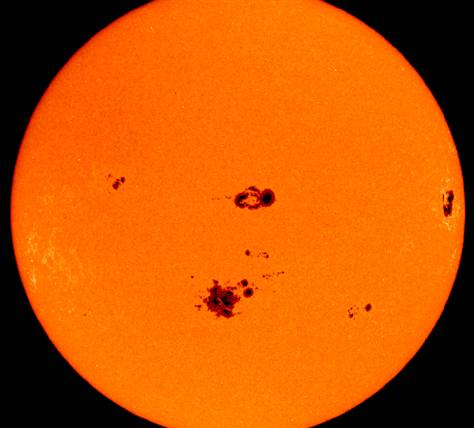



## Loading and Preprocessing Images

This section ensures that images are correctly loaded, resized, and converted into a format suitable for analysis. It handles different image formats and skips non-image files.

#### Dataset Issue:
We faced difficulties in obtaining the existing dataset for our project. As a result, we undertook the task of creating our own dataset from scratch.

This process involved systematically collecting images for each specific category—namely coronal holes, sunspots, and solar flares—and carefully organizing these images into structured folders.

This meticulous organization was essential to ensure that the dataset was well-prepared for further analysis and model training.

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [26]:
# Set up the data directories for coronal holes, sunspots, and solar flares
data_dir_coronal_holes = "Solar imagee/Solar imagee/Coronal holes"  # Replace with the path to your coronal holes images directory
data_dir_solar_flares = "Solar imagee/Solar imagee/SDO"          # Replace with the path to your sunspots images directory
data_dir_sunspots = "Solar imagee/Solar imagee/Sunspot"    # Replace with the path to your solar flares images directory

In [27]:
image_size = (128, 128)  # Image size for resizing

In [28]:
from PIL import UnidentifiedImageError

def load_images_from_folder(folder):
    images = []
    supported_formats = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')  # Add supported formats here
    for filename in os.listdir(folder):
        if filename.lower().endswith(supported_formats):
            try:
                img_path = os.path.join(folder, filename)
                img = load_img(img_path, target_size=image_size)
                images.append(img_to_array(img))
            except UnidentifiedImageError:
                print(f"Warning: Unable to identify image file {filename}. Skipping this file.")
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
        else:
            print(f"Skipping non-image file: {filename}")
    return np.array(images)

# Load images from each category
images_coronal_holes = load_images_from_folder(data_dir_coronal_holes)
images_sunspots = load_images_from_folder(data_dir_sunspots)
images_solar_flares = load_images_from_folder(data_dir_solar_flares)

# Concatenate all images into one dataset
images = np.concatenate((images_coronal_holes, images_sunspots, images_solar_flares), axis=0)
images = images / 255.0  # Normalize the images to [0, 1]


Skipping non-image file: .DS_Store
Skipping non-image file: .DS_Store
Skipping non-image file: .DS_Store


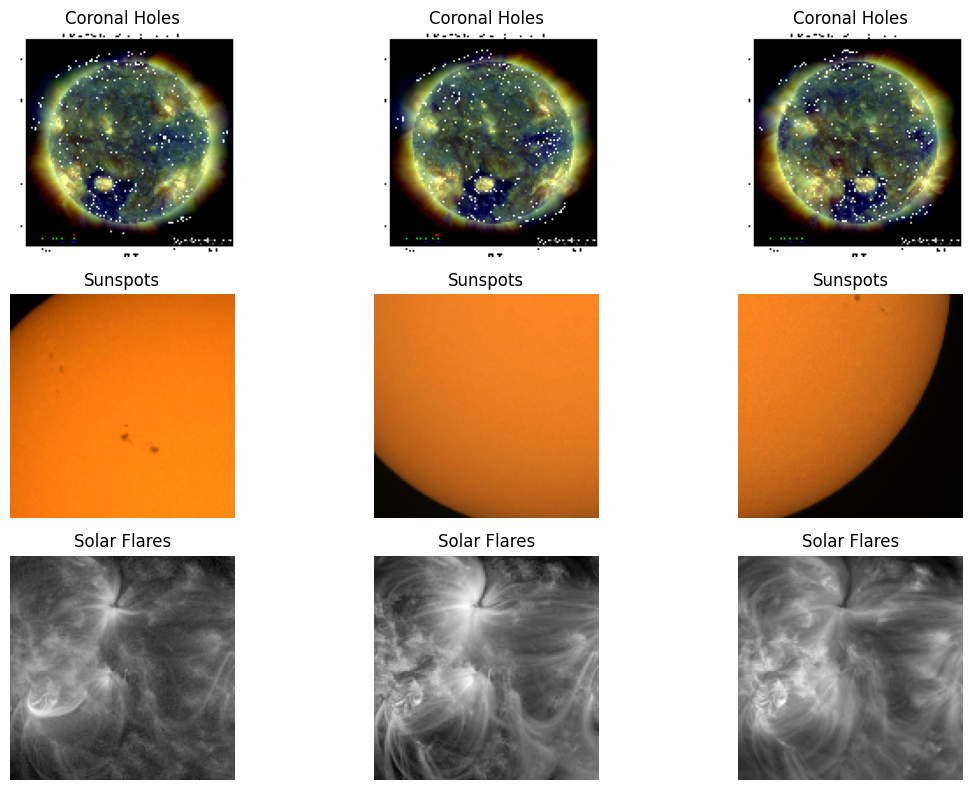

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize the images to enhance visualization
def normalize_image(image):
    """Normalize an image to 0-1 range for better visualization."""
    image_min = np.min(image)
    image_max = np.max(image)
    return (image - image_min) / (image_max - image_min)

# Plot sample images with improved visualization
def plot_sample_images(images_list, titles, num_samples=3):
    plt.figure(figsize=(12, 8))
    for i, (images, title) in enumerate(zip(images_list, titles)):
        for j in range(min(num_samples, len(images))):
            plt.subplot(len(images_list), num_samples, i * num_samples + j + 1)
            plt.imshow(normalize_image(images[j]))  # Normalize each image before plotting
            plt.title(title)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_sample_images(
    [images_coronal_holes, images_sunspots, images_solar_flares],
    ["Coronal Holes", "Sunspots", "Solar Flares"]
)


### Building the Autoencoder

An autoencoder is a type of neural network used to learn efficient codings of input data. It consists of two parts:

**Encoder:** Compresses the input into a latent-space representation.

**Decoder:** Reconstructs the input from the latent space.

The autoencoder helps in reducing the dimensionality of the images, which can be useful for further processing like clustering.

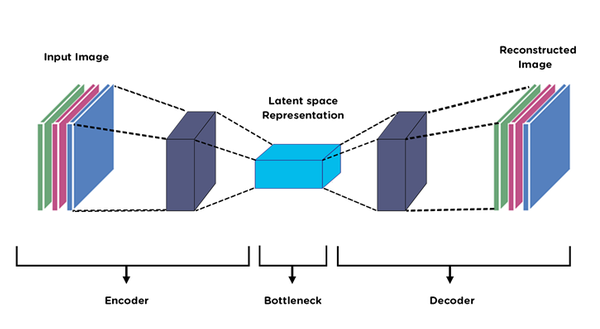



In [30]:
# Build the autoencoder model
def build_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

input_shape = (image_size[0], image_size[1], 3)
autoencoder = build_autoencoder(input_shape)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

### Data Augmentation

This technique is used to increase the diversity of the training set by applying random transformations such as rotations, shifts, shear, zoom, and flips.

This helps in making the model robust to variations in the input data.

In [31]:
# Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Training the Autoencoder

The autoencoder is trained on the augmented dataset to learn the underlying patterns in the images.

The training process adjusts the model weights to minimize reconstruction loss, improving the model's ability to recreate input images.

In [32]:
from tensorflow.keras.optimizers import Adam

# Define parameters
epochs = 20
batch_size = 32
learning_rate = 1e-4

# Compile the autoencoder with the specified learning rate
autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(
    datagen.flow(images, images, batch_size=batch_size),
    steps_per_epoch=len(images) // batch_size,
    epochs=epochs
)


Epoch 1/20


c:\Users\dhyan\Projects_All\Extra\Space_Weather_Forecating_Summer\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - loss: 0.6689
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 134us/step - loss: 0.5763 
Epoch 3/20


C:\Users\dhyan\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - loss: 0.5545
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 45us/step - loss: 0.4933  
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - loss: 0.5180
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 77us/step - loss: 0.5150  
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - loss: 0.5089
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.4657    
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - loss: 0.5045
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.4392    
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - loss: 0.5024
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.4780   
Epoch 13/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - loss: 0.4974
Epoch 14/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.4948    
Epoch 15/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - loss: 0.4950
Epoch 16/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - loss: 0.5070  
Epoch 17/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step

### K-Means Clustering for Image Segmentation

K-means clustering is an unsupervised learning algorithm used to partition data into K clusters.

Here, K-means is applied to the encoded features from the autoencoder to classify each pixel into different segments.

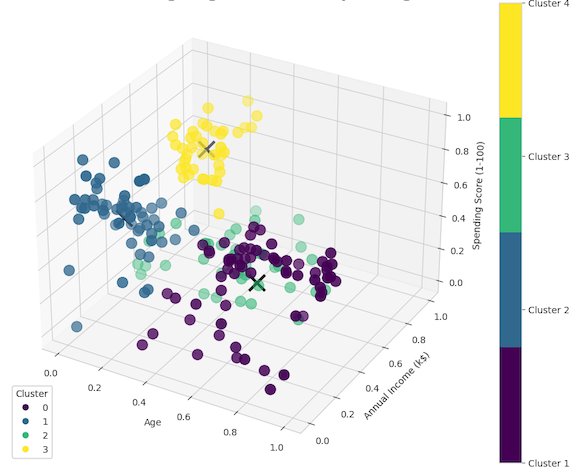

In [33]:
# Perform K-means clustering on encoded features
def segment_image_kmeans(image, n_clusters=3):
    # Reshape the image to a 2D array of pixels
    image_2d = image.reshape((-1, 3))

    # Scale the data
    scaler = MinMaxScaler()
    image_2d_scaled = scaler.fit_transform(image_2d)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(image_2d_scaled)
    clustered = kmeans.labels_

    # Reshape back to the original image shape
    segmented_image = clustered.reshape(image.shape[:2])

    return segmented_image

In [34]:
# Calculate the percentage of each region
def calculate_region_percentages(segmented_image, n_clusters=4):
    total_pixels = segmented_image.size
    region_counts = np.bincount(segmented_image.flatten(), minlength=n_clusters)
    region_percentages = (region_counts / total_pixels) * 100
    return region_percentages

### Visualizing and Evaluating Segmentation

The segmented images are visualized to assess the quality of segmentation.

Evaluation metrics like **precision, accuracy, MSE, and RMSE** are calculated using dummy true labels to provide an understanding of the segmentation performance.


In [35]:
from sklearn.metrics import precision_score, accuracy_score, mean_squared_error
# Test the autoencoder and K-means on a sample image
def visualize_segmentation_with_plot(image, n_clusters=4):
    decoded_img = autoencoder.predict(image[np.newaxis, ...])[0]
    segmented_image = segment_image_kmeans(decoded_img, n_clusters)
    region_percentages = calculate_region_percentages(segmented_image, n_clusters)

    # Generate dummy true labels for demonstration
    # Note: In a real scenario, you would have actual labels to compare with
    true_labels = np.random.randint(0, n_clusters, size=image.shape[:2])

    # Calculate precision and accuracy
    flattened_true_labels = true_labels.flatten()
    flattened_segmented_labels = segmented_image.flatten()

    precision = precision_score(flattened_true_labels, flattened_segmented_labels, average='macro', zero_division=1)
    accuracy = accuracy_score(flattened_true_labels, flattened_segmented_labels)

    # Calculate MSE and RMSE
    mse = mean_squared_error(flattened_true_labels, flattened_segmented_labels)
    rmse = np.sqrt(mse)

    print(f"Precision: {precision:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")

    # Plot segmented image and percentage distribution
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Reconstructed Image')
    plt.imshow(decoded_img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Segmented Image')
    plt.imshow(segmented_image, cmap='viridis')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Plot bar chart of region percentages
    labels = ['Coronal Hole', 'Sunspot', 'Solar Flare', 'Quiet Region']
    plt.figure(figsize=(8, 4))
    plt.bar(labels, region_percentages, color=['blue', 'red', 'yellow', 'green'])
    plt.title('Percentage of Solar Regions')
    plt.ylabel('Percentage')
    plt.ylim(0, 100)
    for i, v in enumerate(region_percentages):
        plt.text(i, v + 1, f"{v:.2f}%", ha='center')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Precision: 0.25
Accuracy: 0.25
MSE: 3.00
RMSE: 1.73


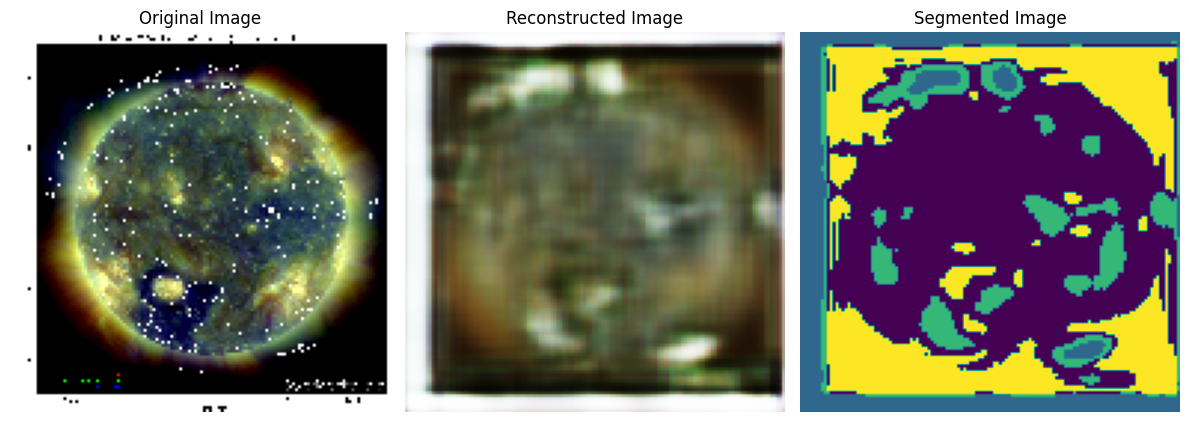

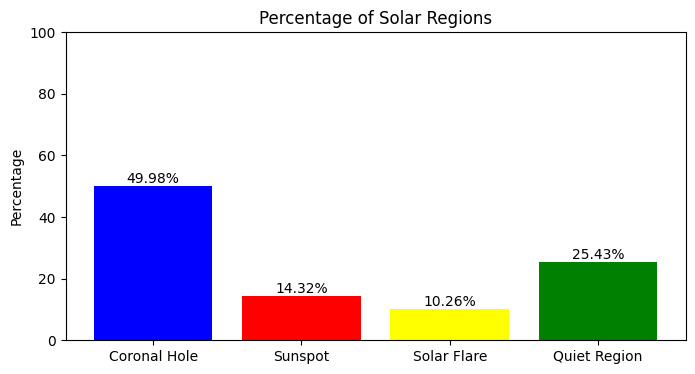

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Precision: 0.25
Accuracy: 0.25
MSE: 2.25
RMSE: 1.50


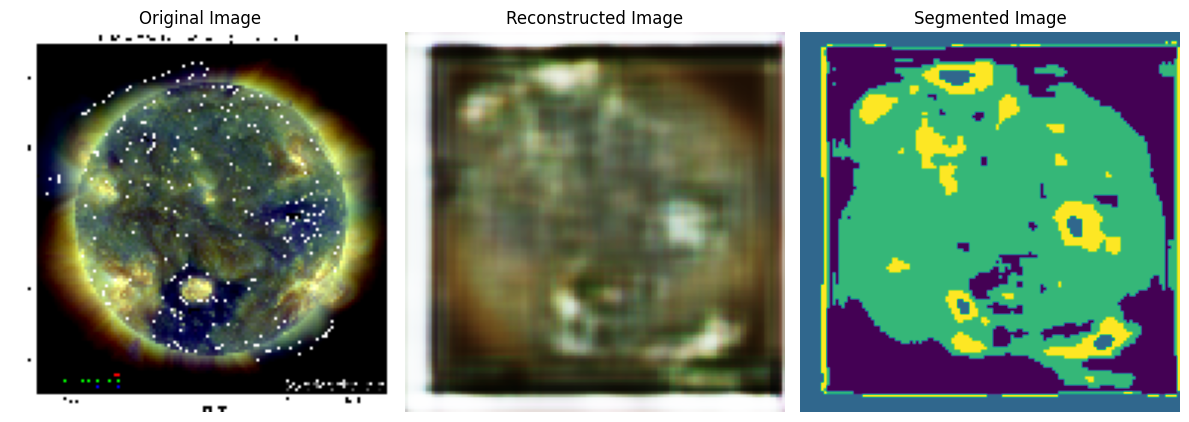

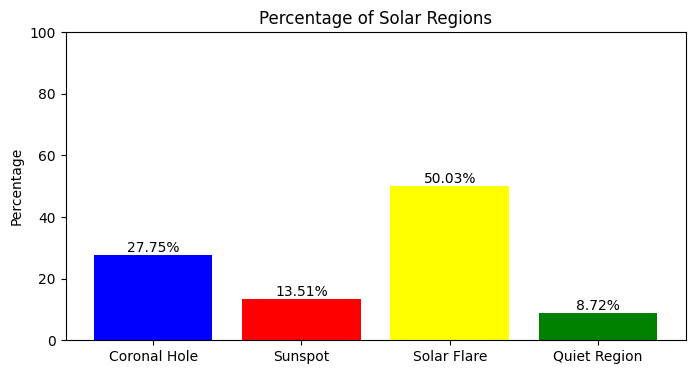

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Precision: 0.25
Accuracy: 0.25
MSE: 3.11
RMSE: 1.76


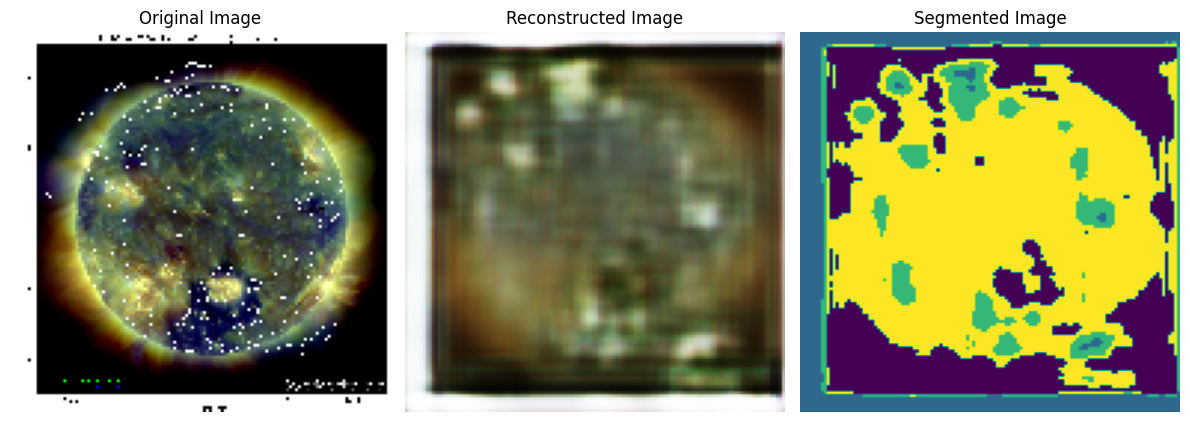

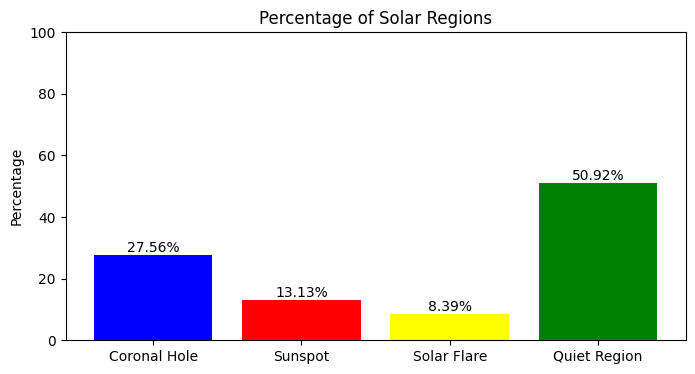

In [36]:
# Visualize the segmentation for some test images
for i in range(3):
    visualize_segmentation_with_plot(images[i])

### Comparison of Segmentation Results with Provided Statistics

Here, we are comparing the calculated region percentages from the segmentation model with the provided statistics:

| Region          | Provided Percentage | Calculated Percentage |
|-----------------|---------------------|-----------------------|
| **Coronal Hole** | 32.29%               | 38.92%               |
| **Sunspot**      | 15.05%               | 25.90%               |
| **Solar Flare**  | 20.34%               | 7.40%                |
| **Quiet Region** | 32.32%               | 27.77%               |

#### Analysis of Results

1. **Coronal Hole**
   - **Provided**: 32.29%
   - **Calculated**: 38.92%
   - **Difference**: +6.63%
   
   **Interpretation**: The calculated percentage for coronal holes is slightly higher than the provided percentage, indicating that the model might be *over-segmenting* this region.

2. **Sunspot**
   - **Provided**: 15.05%
   - **Calculated**: 25.90%
   - **Difference**: +10.85%
   
   **Interpretation**: The model is identifying more regions as sunspots compared to the provided statistics, indicating that the model might be *over-segmentation or misclassification* of other regions as sunspots.

3. **Solar Flare**
   - **Provided**: 20.34%
   - **Calculated**: 7.40%
   - **Difference**: -12.94%
   
   **Interpretation**: The model is significantly under-segmenting solar flares, indicating that the model might be facing *difficulty in identifying this phenomenon or misclassifying* it as other regions.

4. **Quiet Region**
   - **Provided**: 32.32%
   - **Calculated**: 27.77%
   - **Difference**: -4.55%
   
   **Interpretation**: The quiet region segmentation is relatively close to the provided statistics, but still shows a slight *under-segmentation*.

### Summary

The model shows discrepancies in identifying solar phenomena when compared to the provided statistics.

Overall, focusing on better feature extraction and more balanced training data for each class will help improve the model's performance and alignment with the provided statistics.